# Log
- optimization averege across different confusion matrices - that seems to have a big effect on the performance of enabling surrogate

# TODO
 - keep the confusion matrix estimation same - across all trials?
 - double check that params are getting properly propagated for the Agent and environment
 - ~~grid search for parameters~~
 - figure out parameters in surrogate rewards
 - ~~make rewards non binary in environment and surrogate rewards~~
 - ~~add deceay from papers, log and other~~
 - ~~initiate q-table at `-1`?~~
 - run experiment with different `correct_action`
 - should we be setting up the glove for `very distinguishable` levels? Shouldn't we set it up with `barely distinguishable` levels, as this is where the perturbed rewards come on - they'd help us get through the noise and find the correct level.

# Imports

In [1]:
import collections
import pandas as pd
import argparse
import time
import numpy as np

In [2]:
import noise_estimator

In [3]:
from ucbq_agent_stateless import UCBQAgent
from ucbq_environment_stateless import ModifiedRandomEnvironment

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm 
import utils

from modified_pendulum_processor import ModifiedPendulumProcessor

from utils import *

# Params

In [5]:
def default_params():
    """ These are the default parameters used in the framework. """
    return {
            # Runner parameterr
            'max_steps': 120,
            'num_episodes': 100,
            'num_actions': 7, 
            'start_action': 0, 
            'correct_action': 1,    # Zero indexed 
            # 'multi_runner': False,            # uses multiple runners if True
            # Optimization parameters
            'alpha': 0.5,                       # learning rate of optimizer
            'alpha_decay': 40,
            'alpha_min': 0.001,
            # Exploration parameters
            'epsilon': 1,               # annealing starts at this epsilon
            'epsilon_decay': 20,
            'epsilon_min': 0.01,    
            'gamma': 0.95,                    # discount factor gamma
            'plots': False,
            'noise': True,
            'surrogate': False,            
           }

# Real rewards UCB Q-learning

In [6]:
params = default_params()
params['noise'] = False

agent = UCBQAgent()

runner(agent=agent)
utils.print_agent_stats(agent)

Q-table:
[[-6 -7 -5 -4 -4 -4  0]]
Number of times action was taken:
[[ 2.  2.  2.  3.  4.  4. 39.]]
Total timesteps:
50


 82%|████████▏ | 82/100 [00:00<00:00, 814.97it/s]

100%|██████████| 100/100 [00:00<00:00, 797.14it/s]

Accuracy: 100.0
Mean episode length: 50.0


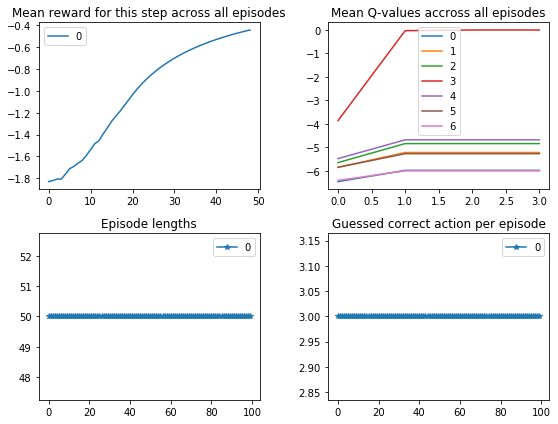

In [7]:
params = default_params()
params['noise'] = False
params['plots'] = True

# The Q-value shape make sense - we're trying higher numbers later
# so they converge to -1 slower than e.g. action 0 or 1
plot_mean_q_values()

# Noisy rewards
- rewards are now noisy
- q-learner hasn't changed

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

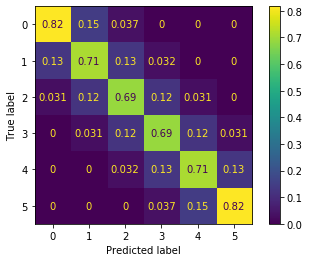

True

In [9]:
params = default_params()
num_actions = params['num_actions']
correct_action = params['correct_action']
# Confusion matrix used as noise
num_unique_rewards = utils.get_num_unique_rewards(num_actions=num_actions, correct_action=correct_action)
cmat = ModifiedPendulumProcessor(num_unique_rewards=num_unique_rewards).initialize_cmat(diag=0.69)
ConfusionMatrixDisplay(confusion_matrix=cmat).plot()
plt.show()
noise_estimator.is_invertible(cmat)

100%|██████████| 100/100 [00:00<00:00, 669.36it/s]


Accuracy: 86.0
Mean episode length: 50.31
Last reward processor:
Estimated confusion matrix:


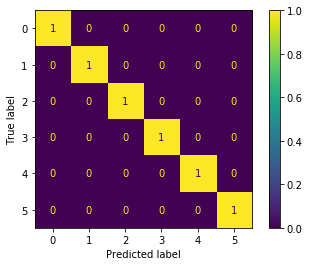

Reward sets:
{(0, 2): [-1, -1], (0, 1): [0, 0, -1, 0, -1, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, -1, 0, 0, 0, -1, 0, 0, 0, 0], (0, 3): [-1], (0, 4): [-1], (0, 6): [-4], (0, 5): [-5, -3]}
Reward set counts:
Key (0, 2): 2 items
Key (0, 1): 42 items
Key (0, 3): 1 items
Key (0, 4): 1 items
Key (0, 6): 1 items
Key (0, 5): 2 items


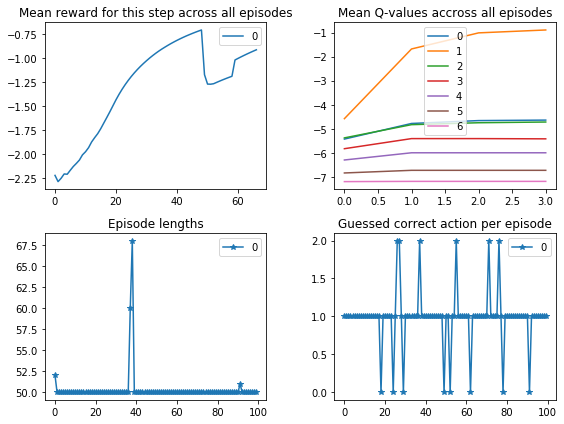

In [10]:
# res = {'target': 95.89999999999999, 'params': {'alpha': 0.8236118040381998, 'alpha_decay': 243.0544785033269, 'alpha_min': 0.5113965695937486, 'epsilon': 0.25289603267158034, 'epsilon_decay': 70.53090930872196, 'epsilon_min': 0.044310479986752194, 'gamma': 0.8871072251030447, 'surrogate_c_interval': 67.76179038423699}}
# params=res['params']
params = default_params()
params['plots'] = True
plot_mean_q_values(params=params)

# Surrogate rewards

100%|██████████| 100/100 [00:00<00:00, 644.05it/s]


Accuracy: 86.0
Mean episode length: 50.44
Last reward processor:
Estimated confusion matrix:


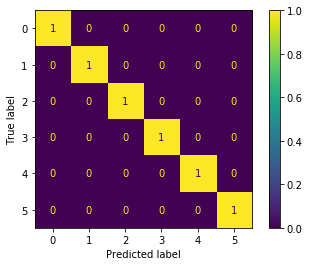

Reward sets:
{(0, 2): [0, -1, -2, -1], (0, 0): [-1], (0, 4): [-4], (0, 3): [-3], (0, 1): [0, 0, 0, 0, -1, -1, 0, 0, -2, -1, -1, -2, -2, 0, 0, 0, 0, 0, 0, -2, -1, -1, -2, -1, 0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0], (0, 5): [-4, -4], (0, 6): [-5]}
Reward set counts:
Key (0, 2): 4 items
Key (0, 0): 1 items
Key (0, 4): 1 items
Key (0, 3): 1 items
Key (0, 1): 39 items
Key (0, 5): 2 items
Key (0, 6): 1 items


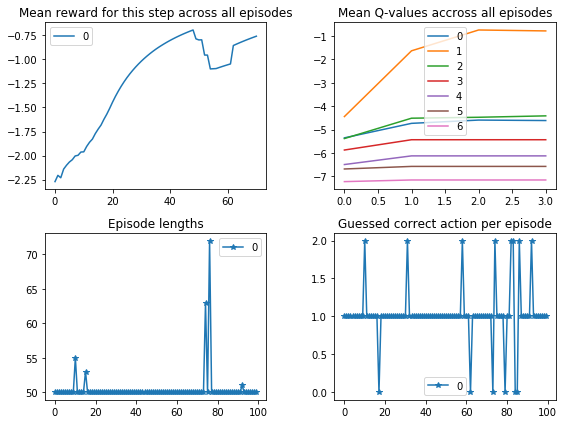

In [11]:
params_new ={'noise': True, 'surrogate': True, 'plots': True, 'surrogate_c_interval': 20}
params = default_params() | params
plot_mean_q_values(params = params)

# Sanity check

In [12]:
params = default_params()

print('Accuracy should be higher, timesteps should be lower')

params['noise'] = False
params['surrogate'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['noise'] = True
params['surrogate'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['noise'] = True
params['surrogate'] = True
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

Accuracy should be higher, timesteps should be lower


100%|██████████| 100/100 [00:00<00:00, 951.86it/s]


100.0 50.0


100%|██████████| 100/100 [00:00<00:00, 678.63it/s]


89.0 50.25


100%|██████████| 100/100 [00:00<00:00, 504.83it/s]

86.0 50.43


# Bayesian optimization

In [13]:
# | 24        | 100.0     | 0.9026    | 826.9     | 0.0       | 73.21     |
# this with noise True and surrogate False
# no alpha decay
# | 184       | 99.0      | 0.8236    | 243.1     | 0.5114    | 0.2529    | 70.53     | 0.04431   | 0.8871    | 67.76     |

In [14]:
from bayes_opt import BayesianOptimization

In [16]:
def objective(
        alpha,
        # alpha_decay,
        alpha_min,
        epsilon,
        epsilon_decay,
        epsilon_min,
        gamma,
        # surrogate_c_interval,
        ):
    # # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # # 'surrogate_lr'    
    # convergence_number_of_consequent_actions
    # intial_q_values: [0, -7]

    # surrogate_c_interval = int(surrogate_c_interval)

    new_params = {
        'alpha': alpha, 
        # 'alpha_decay': alpha_decay,
        'alpha_min': alpha_min,
        'epsilon': epsilon, 
        'epsilon_decay': epsilon_decay,
        'epsilon_min': epsilon_min,
        'gamma': gamma,
        # 'plots': False,   
        # 'surrogate_c_interval': surrogate_c_interval,
        #
        'noise': True,
        'surrogate': False,
        # 'diag': 0.9     
    }

    params = default_params() | new_params

    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
    


    # params['surrogate'] = False
    # q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy_no_surrogate, _ = qLearningExperiment(params=params)


    # accuracy = accuracy_surrogate - accuracy_no_surrogate
    
    # mean_episode_length = np.mean(episode_lengths)
    # return -mean_episode_length
    return accuracy

optimizer = BayesianOptimization(
    f=objective,
    pbounds={
        'alpha': (0, 1), 
        # 'alpha_decay': (1, 1000),
        'alpha_min': (0, 1),
        'epsilon': (0, 1), 
        'epsilon_decay': (10, 80),
        'epsilon_min': (0, 1),
        'gamma': (0, 1),
        # 'surrogate_c_interval': (1, 120)
        },
    random_state=1,
)

# n_iter: How many steps of bayesian optimization you want to perform. 
# The more steps the more likely to find a good maximum you are.
# init_points: How many steps of random exploration you want to perform.
# Random exploration can help by diversifying the exploration space.
optimizer.maximize(
    init_points=10,
    n_iter=10,
)

best_params = optimizer.max['params']

print(optimizer.max)

|   iter    |  target   |   alpha   | alpha_min |  epsilon  | epsilo... | epsilo... |   gamma   |
-------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:00<00:00, 752.77it/s]


| 1         | 0.0       | 0.417     | 0.7203    | 0.0001144 | 31.16     | 0.1468    | 0.09234   |


100%|██████████| 100/100 [00:00<00:00, 343.63it/s]


| 2         | 37.0      | 0.1863    | 0.3456    | 0.3968    | 47.72     | 0.4192    | 0.6852    |


100%|██████████| 100/100 [00:00<00:00, 780.18it/s]


| 3         | 4.0       | 0.2045    | 0.8781    | 0.02739   | 56.93     | 0.4173    | 0.5587    |


100%|██████████| 100/100 [00:00<00:00, 311.48it/s]


| 4         | 48.0      | 0.1404    | 0.1981    | 0.8007    | 77.78     | 0.3134    | 0.6923    |


100%|██████████| 100/100 [00:00<00:00, 531.54it/s]


| 5         | 95.0      | 0.8764    | 0.8946    | 0.08504   | 12.73     | 0.1698    | 0.8781    |


100%|██████████| 100/100 [00:00<00:00, 337.53it/s]


| 6         | 16.0      | 0.09835   | 0.4211    | 0.9579    | 47.32     | 0.6919    | 0.3155    |


100%|██████████| 100/100 [00:00<00:00, 667.28it/s]


| 7         | 58.0      | 0.6865    | 0.8346    | 0.01829   | 62.51     | 0.9889    | 0.7482    |


100%|██████████| 100/100 [00:00<00:00, 582.08it/s]


| 8         | 6.0       | 0.2804    | 0.7893    | 0.1032    | 41.35     | 0.9086    | 0.2936    |


100%|██████████| 100/100 [00:00<00:00, 771.68it/s]


| 9         | 0.0       | 0.2878    | 0.13      | 0.01937   | 57.52     | 0.2116    | 0.2655    |


100%|██████████| 100/100 [00:00<00:00, 328.44it/s]


| 10        | 48.0      | 0.4916    | 0.05336   | 0.5741    | 20.27     | 0.5893    | 0.6998    |


100%|██████████| 100/100 [00:00<00:00, 410.22it/s]


| 11        | 89.0      | 0.7989    | 0.7253    | 0.1835    | 14.25     | 0.2543    | 0.8422    |


100%|██████████| 100/100 [00:00<00:00, 341.33it/s]


| 12        | 0.0       | 0.0       | 0.0       | 1.0       | 12.55     | 1.0       | 0.0       |


100%|██████████| 100/100 [00:00<00:00, 341.98it/s]


| 13        | 65.0      | 1.0       | 0.1003    | 0.0       | 13.41     | 0.0       | 1.0       |


100%|██████████| 100/100 [00:00<00:00, 685.50it/s]


| 14        | 75.0      | 0.8631    | 0.9695    | 0.01809   | 13.78     | 0.8192    | 0.681     |


100%|██████████| 100/100 [00:00<00:00, 342.93it/s]


| 15        | 57.0      | 1.0       | 1.0       | 0.9773    | 13.5      | 0.0       | 1.0       |


100%|██████████| 100/100 [00:00<00:00, 348.61it/s]


| 16        | 0.0       | 0.03496   | 1.0       | 0.0       | 13.47     | 0.0       | 1.0       |


100%|██████████| 100/100 [00:00<00:00, 417.87it/s]


| 17        | 84.0      | 0.7294    | 0.8606    | 0.1368    | 13.59     | 0.8273    | 0.688     |


100%|██████████| 100/100 [00:00<00:00, 370.99it/s]


| 18        | 71.0      | 1.0       | 0.7268    | 0.1745    | 13.07     | 0.4164    | 0.3973    |


100%|██████████| 100/100 [00:00<00:00, 340.50it/s]


| 19        | 51.0      | 1.0       | 0.3805    | 0.4783    | 13.99     | 0.7338    | 0.9877    |


100%|██████████| 100/100 [00:00<00:00, 693.49it/s]

| 20        | 95.0      | 0.874     | 0.8607    | 0.3341    | 12.26     | 0.04686   | 0.974     |
{'target': 95.0, 'params': {'alpha': 0.8763891522960383, 'alpha_min': 0.8946066635038473, 'epsilon': 0.08504421136977791, 'epsilon_decay': 12.733834826301766, 'epsilon_min': 0.1698304195645689, 'gamma': 0.8781425034294131}}


100%|██████████| 1000/1000 [00:01<00:00, 585.25it/s]


Accuracy: 96.6
Mean episode length: 56.629
Last reward processor:
Estimated confusion matrix:


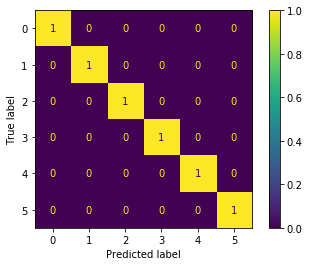

Reward sets:
{(0, 0): [-1, -1], (0, 1): [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, -1, -1, 0, 0, 0, -1, -1, 0, 0, 0, 0], (0, 2): [-1], (0, 3): [-3, -3], (0, 5): [-3], (0, 4): [-3, -3], (0, 6): [-4]}
Reward set counts:
Key (0, 0): 2 items
Key (0, 1): 40 items
Key (0, 2): 1 items
Key (0, 3): 2 items
Key (0, 5): 1 items
Key (0, 4): 2 items
Key (0, 6): 1 items


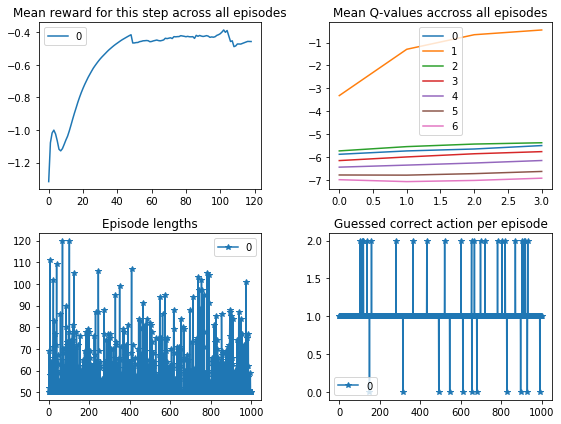

100%|██████████| 1000/1000 [00:01<00:00, 622.61it/s]


Accuracy: 96.1
Mean episode length: 56.648
Last reward processor:
Estimated confusion matrix:


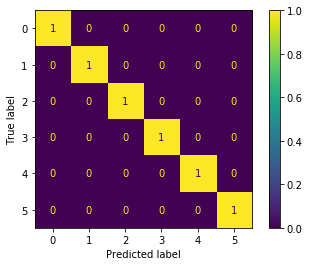

Reward sets:
{(0, 2): [-1], (0, 0): [-1], (0, 1): [0, -1, -1, 0, 0, 0, 0, -2, -1, -1, -1, -1, 0, 0, -2, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, -2, 0, 0, 0, -1, 0, 0, -2, 0, 0, -2, 0, -2, -2, -1, -1], (0, 3): [-2], (0, 6): [-5, -4]}
Reward set counts:
Key (0, 2): 1 items
Key (0, 0): 1 items
Key (0, 1): 44 items
Key (0, 3): 1 items
Key (0, 6): 2 items


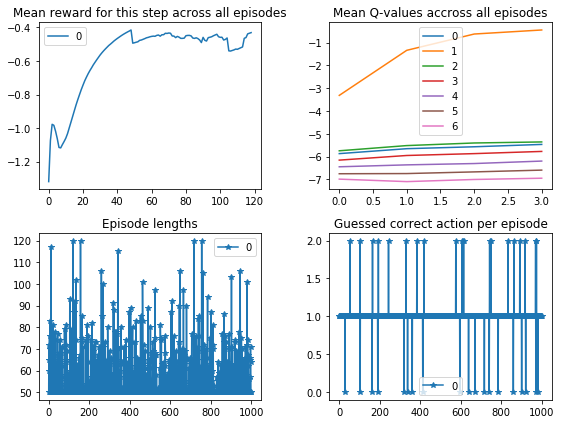

In [53]:
res = {'target': 95.89999999999999, 'params': {'alpha': 0.8236118040381998, 'alpha_decay': 243.0544785033269, 'alpha_min': 0.5113965695937486, 'epsilon': 0.25289603267158034, 'epsilon_decay': 70.53090930872196, 'epsilon_min': 0.044310479986752194, 'gamma': 0.8871072251030447, 'surrogate_c_interval': 67.76179038423699}}
params=res['params']

params['noise'] = True
params['surrogate'] = False
plot_mean_q_values(params=params)

params['surrogate'] = True
plot_mean_q_values(params=params)

# TODO

In [22]:
import numpy as np
from bayes_opt import BayesianOptimization
from pymoo.optimize import minimize
from pymoo.util import plotting
from pymoo.model.problem import Problem

max_steps = 120
num_episodes = 100

class QLearningProblem(Problem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=np.array([0, 0, 10]), xu=np.array([1, 1, 80]))
    
    def _evaluate(self, X, out, *args, **kwargs):
        alpha, epsilon, epsilon_decay = X

        # Run your Q-learning experiment with given parameters
        params = {'alpha': alpha, 'epsilon': epsilon, 'epsilon_decay': epsilon_decay}
        q_values_all_experiments, _, episode_lengths, _, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)

        # Maximize accuracy
        out["F"] = [-accuracy, -np.mean(episode_lengths)]

problem = QLearningProblem()

algorithm = minimize(
    algorithm="nsga2",
    problem=problem,
    termination=("n_gen", 20),  # Adjust the number of generations as needed
    save_history=True,
    verbose=True,
)

# Get the best solution from the Pareto front
best_solution = algorithm.result[0]

best_alpha, best_epsilon, best_epsilon_decay = best_solution.X

print(f"Best alpha: {best_alpha}")
print(f"Best epsilon: {best_epsilon}")
print(f"Best epsilon_decay: {best_epsilon_decay}")
print(f"Best accuracy: {-best_solution.F[0]}")
print(f"Best mean_episode_length: {-best_solution.F[1]}")

# You can visualize the Pareto front using pymoo's plotting functions
plotting.plot(obj_space=algorithm.result.F, ideal_point=np.array([0, 0]), title="Pareto Front")


ModuleNotFoundError: No module named 'pymoo'

# Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
from IPython import display
import pandas as pd

In [ ]:
max_steps = 120
num_episodes = 20

param_grid = {
    'alpha': [0, 1.0],
    # 'alpha_decay'
    # alpha_min
    'epsilon': [0, 1.0],
    # 'epsilon_decay': [0.1, 1.0],
    # 'gamma'
    'epsilon_decay': [10, 20, 40, 80],
    # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # 'surrogate_lr'
    }

param_grid_out = pd.DataFrame(ParameterGrid(param_grid))

def get_results_from_grid_row(params):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)
    mean_episode_length = np.mean(episode_lengths)
    print(accuracy, mean_episode_length) 

    return accuracy, mean_episode_length

for i, params in tqdm(param_grid_out.iterrows(), total=param_grid_out.shape[0]):
    accuracy, mean_episode_length = get_results_from_grid_row(params)
    param_grid_out.loc[i, 'accuracy'] = accuracy
    param_grid_out.loc[i, 'mean_episode_length'] = mean_episode_length
    # display.clear_output()

  6%|▋         | 1/16 [00:11<02:47, 11.14s/it]

0.0 121.0


  6%|▋         | 1/16 [00:22<05:40, 22.68s/it]


KeyboardInterrupt: 

In [ ]:
# param_grid_out.iloc[0]['accuracy'] = 1
print(param_grid_out.sort_values(by=['accuracy', 'mean_episode_length'], ascending=False))

    alpha  epsilon  epsilon_decay  accuracy  mean_episode_length
1     0.1      0.1             20      95.0                73.70
7     0.1      1.0             80      90.0                82.70
15    1.0      1.0             80      85.0                91.00
4     0.1      1.0             10      85.0                83.35
10    1.0      0.1             40      85.0                78.55
5     0.1      1.0             20      85.0                75.75
12    1.0      1.0             10      80.0                80.90
6     0.1      1.0             40      75.0                78.45
11    1.0      0.1             80      75.0                78.45
14    1.0      1.0             40      75.0                77.20
8     1.0      0.1             10      75.0                74.95
2     0.1      0.1             40      70.0                87.90
13    1.0      1.0             20      70.0                82.85
3     0.1      0.1             80      65.0                82.65
0     0.1      0.1       

# Epsilon test

In [21]:
np.log10(20+1)

1.3222192947339193

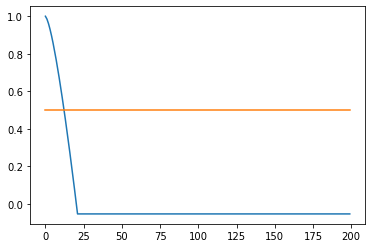

In [28]:
agent = UCBQAgent()
epsilons = []
for t in range(200):
    epsilons.append(agent.epsilon)
    agent.choose_action(0)

plt.plot(epsilons)

agent = UCBQAgent()
alphas = []
for t in range(200):
    alphas.append(agent.alpha)
    agent.choose_action(0)

plt.plot(alphas)

# Surrogate rewards without adding noise

In [25]:
from modified_pendulum_processor_noiseless import ModifiedPendulumProcessorNoiseless

In [26]:
post_processor_surrogate = ModifiedPendulumProcessorNoiseless()

def adjust_rewards_surrogate(reward, state, action):    
    observation, reward, done, info = post_processor_surrogate.process_step(state, reward, None, None, action)
    return reward

plot_mean_q_values(adjust_rewards_surrogate)

print(post_processor_surrogate.cmat)
print(post_processor_surrogate.r_sets)
print('Estimated confusion matrix:')
print(np.around(post_processor_surrogate.C, decimals=4))

TypeError: 'NoneType' object cannot be interpreted as an integer